# GPR Data Access and Processing
This notebook is designed to obtain snow depth, density, and SWE from ground-penetrating radar data. We will use GPR data gathered during the SnowEx Alaska campaigns.

The text and code in this notebook is adapted from Randall Bonnell's tutorial on lidar and GPR during the 2024 SnowEx Hackweek, found here: https://snowex-2024.hackweek.io/tutorials/gpr_lidar/GPR_Lidar_HackweekTutorial.html

# 1. GPR Methods for the Retrieval of Snow Depth and SWE

## What is GPR?
* GPR transmits a radar signal into the snowpack, which then reflects off objects/interfaces with contrasting dielectric permittivity. The GPR records the **amplitude** and **two-way travel time (twt)** of the reflections.
* **Dielectric permittivity** refers to the dielectric properties of the snowpack that define how EM energy trasmits through the medium.
* Usually, we are interested in the snow-ground interface, and we measure the snowpack thickness (depth) in two-way travel time (in nanoseconds).
* Most analysis-ready GPR products have twt, snow depth, and SWE variables. Some have also been updated to include derived snow density

For this notebook, we will start from the two-way travel time data to derive our snow properties of interest, and compare it to airborne lidar data. The `snowexsql` package will be needed.

Note that the results derived here are for the user's reference - most of the GPR products posted on NSIDC already have snow depth and SWE available as variables.

# 2. SnowEx23 GPR/Lidar Derived Permittivities/Densities in the Boreal Forest, Alaska

## Deriving Snow Density at Farmer's Loop/Creamer's Field
For this first step, we will use:
1. Airborne lidar data collected on 11 March, 2023.
2. GPR data collected on 7, 11, 13, and 16 March, 2023.

In [1]:
# Auxiliary packages
import os
import numpy as np 
from datetime import date
from scipy.spatial import cKDTree

# Plotting packages
import matplotlib.pyplot as plt
from rasterio.plot import show

# Geospatial packages
import geopandas as gpd #for vector data
import xarray as xr
import rioxarray #for raster data
import pandas as pd
from shapely.geometry import box, Point
import rasterio as rio

# Import SnowEx database
from snowexsql.api import PointMeasurements, LayerMeasurements, RasterMeasurements

In [2]:
import sqlalchemy
import rasterio

print(pd.__version__)
print(sqlalchemy.__version__)
print(rasterio.__version__)

2.3.3
2.0.44
1.4.3


### Load GPR Data from the SnowEx Database
Thanks goes to Micah Johnson and Micah Sandusky from M3Works for their development of the SnowEx Database.

We will focus on a single date for the GPR data to limit the memory usage needed for data accessing and processing. The GPR data is in CSV format, so we will use `pandas` to load the data directly.

In [3]:
# Set a date of interest
dt = date(2023, 3, 11)

# Define site of interest
site = LayerMeasurements.from_filter(date=dt,
                                     site_name='Fairbanks',
                                     site_id='FLCF',
                                     limit=1
                                    )

# Use pandas to read in GPR data
gpr_df = PointMeasurements.from_area(pt=site.geometry[0],
                                     crs=26906,
                                     buffer=10000,
                                     type='two_way_travel',
                                     observers='Randall Bonnell',
                                     date=dt,
                                     site_name='farmers-creamers',
                                     limit=20213 # Expected number of measurements
                                    )

gpr_df.head()

,version_number,equipment,value,latitude,longitude,northing,easting,elevation,utm_zone,geom,...,date,time_created,time_updated,id,doi,date_accessed,instrument,type,units,observers
0,None,None,2.993355,64.873572,-147.695581,7.194546e+06,467044.267331,None,6,POINT (467044.267 7194545.619),...,2023-03-11,2024-08-18 02:41:55.743293+00:00,None,7418573,None,2024-08-18,pulseEkko pro 1 GHz GPR,two_way_travel,ns,Randall Bonnell
1,None,None,2.750000,64.873587,-147.695533,7.194547e+06,467046.578651,None,6,POINT (467046.579 7194547.363),...,2023-03-11,2024-08-18 02:41:55.743293+00:00,None,7418603,None,2024-08-18,pulseEkko pro 1 GHz GPR,two_way_travel,ns,Randall Bonnell
2,None,None,2.842746,64.873572,-147.695580,7.194546e+06,467044.351761,None,6,POINT (467044.352 7194545.672),...,2023-03-11,2024-08-18 02:41:55.743293+00:00,None,7418574,None,2024-08-18,pulseEkko pro 1 GHz GPR,two_way_travel,ns,Randall Bonnell
3,None,None,2.450000,64.873588,-147.695531,7.194547e+06,467046.657725,None,6,POINT (467046.658 7194547.424),...,2023-03-11,2024-08-18 02:41:55.743293+00:00,None,7418604,None,2024-08-18,pulseEkko pro 1 GHz GPR,two_way_travel,ns,Randall Bonnell
4,None,None,2.250000,64.873589,-147.695530,7.194547e+06,467046.737106,None,6,POINT (467046.737 7194547.485),...,2023-03-11,2024-08-18 02:41:55.743293+00:00,None,7418605,None,2024-08-18,pulseEkko pro 1 GHz GPR,two_way_travel,ns,Randall Bonnell


Let's take a look at the distribution of GPR two-way travel time. We will also estimate snow depth from twt and plot that.

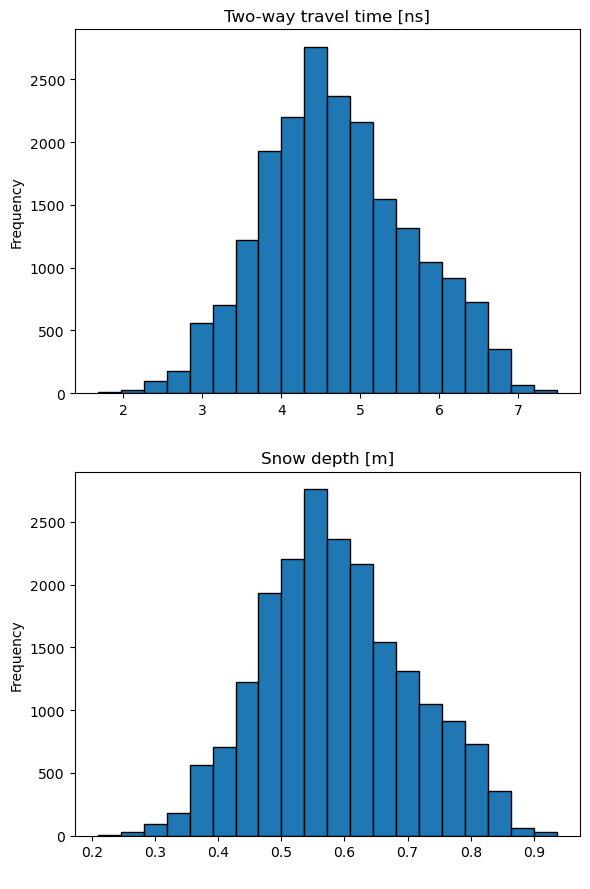

In [4]:
# Estimate snow depth from the two-way travel time
gpr_df['Depth_estimated'] = 0.25 * (gpr_df['value']/2)

# Make histograms of two-way travel time and snow depth
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(6, 9))
gpr_df.plot.hist(ax=ax1, column='value', bins=20, edgecolor='black', legend=False)
ax1.set_xlabel(' ')
ax1.set_title('Two-way travel time [ns]')

gpr_df.plot.hist(ax=ax2, column='Depth_estimated', bins=20, edgecolor='black', legend=False)
ax2.set_xlabel(' ')
ax2.set_title('Snow depth [m]')

plt.tight_layout()

### Load Lidar-Derived Canopy Height and Snow Depth
To compare against the GPR data, we will load airborne lidar data products, specifically canopy height and snow depths. To facilitate our analysis, we will create a bounding box for the lidar results using our GPR data.

In [5]:
# Extract x/y limit from GPR data
bounds = gpr_df.total_bounds

# Create a bounding box
gpr_limits = box(*bounds)

Aside from this bounding box, accessing the lidar data is very similar to the GPR data. However, because the lidar data is much larger, loading it through the database may take a few minutes.

In [12]:
# Load lidar canopy heights
flcf_ch = RasterMeasurements.from_area(shp=gpr_limits,
                                      crs=26906,
                                      buffer=None,
                                      type='canopy_height',
                                      site_name='farmers-creamers',
                                      observers='chris larsen'
                                      )
print(flcf_ch)

<closed DatasetReader name='/vsimem/36f94238-1d1b-40e8-b3fc-4ff48c598ec8/36f94238-1d1b-40e8-b3fc-4ff48c598ec8.tif' mode='r'>


In [ ]:
# Make a sample plot of canopy height and the GPR track
# NEEDS FIXING: can't plot a closed dataset
""" fig, ax = plt.subplots()
with rio.open(flcf_ch.name) as src:
    show(src, ax=ax, cmap='Greens', clim=(0,5))
gpr_df.plot(ax=ax, color='blue', markersize=10)
plt.tight_layout() """

" fig, ax = plt.subplots()\nwith rio.open(flcf_ch.name) as src:\n    show(src, ax=ax, cmap='Greens', clim=(0,5))\ngpr_df.plot(ax=ax, color='blue', markersize=10)\nplt.tight_layout() "

In [14]:
# Load lidar snow depths
flcf_sd = RasterMeasurements.from_area(shp=gpr_limits,
                                       crs=26906,
                                       buffer=None,
                                       type='depth',
                                       site_name='farmers-creamers',
                                       observers='chris larsen'
                                      )
print(flcf_sd)

<closed DatasetReader name='/vsimem/338ca717-1216-4238-9621-7a3e5ecfb425/338ca717-1216-4238-9621-7a3e5ecfb425.tif' mode='r'>


In [16]:
# Make a sample plot of snow depth and the GPR track
# NEEDS FIXING
""" fig, ax = plt.subplots()
show(flcf_sd, ax=ax, cmap='Blues', clim=(0,1.5))
gpr_df.plot(ax=ax, color='orange', markersize=10) """

" fig, ax = plt.subplots()\nshow(flcf_sd, ax=ax, cmap='Blues', clim=(0,1.5))\ngpr_df.plot(ax=ax, color='orange', markersize=10) "

### Match GPR data with lidar data
To match the GPR and lidar data, we can either rasterize the GPR data or vectorize the lidar data. For simplicity, we will vectorize the lidar data and perform a nearest neighbor search.

The GPR data is ~0.1 m resolution, whereas the lidar data is ~0.5 m resolution. So, we can expect ~5 GPR data points per lidar pixel.

In [18]:
""" # Find height and width of array
height, width = flcf_sd.read(1).shape

# Create arrays of the height, width of the lidar raster
cols, rows = np.meshgrid(np.arange(width), np.arange(height))

# Get the easting/northing from the lidar raster
x_lidar, y_lidar = rio.transform.xy(flcf_sd.transform, rows, cols)

# Vectorize the raster data
x_lidar_vec = np.array(x_lidar).flatten()
y_lidar_vec = np.array(y_lidar).flatten()
flcf_sd_vec = flcf_sd.read().flatten()

# Pull vectors from GPR GeoDataFrame
gpr_arr = np.stack([gpr_df.geometry.x, gpr_df.geometry.y, gpr_df['value']], axis=1)
gpr_x = gpr_arr[:,0]
gpr_y = gpr_arr[:,1]
gpr_twt = gpr_arr[:,2].reshape(len(gpr_arr[:,2]), 1) """

" # Find height and width of array\nheight, width = flcf_sd.read(1).shape\n\n# Create arrays of the height, width of the lidar raster\ncols, rows = np.meshgrid(np.arange(width), np.arange(height))\n\n# Get the easting/northing from the lidar raster\nx_lidar, y_lidar = rio.transform.xy(flcf_sd.transform, rows, cols)\n\n# Vectorize the raster data\nx_lidar_vec = np.array(x_lidar).flatten()\ny_lidar_vec = np.array(y_lidar).flatten()\nflcf_sd_vec = flcf_sd.read().flatten()\n\n# Pull vectors from GPR GeoDataFrame\ngpr_arr = np.stack([gpr_df.geometry.x, gpr_df.geometry.y, gpr_df['value']], axis=1)\ngpr_x = gpr_arr[:,0]\ngpr_y = gpr_arr[:,1]\ngpr_twt = gpr_arr[:,2].reshape(len(gpr_arr[:,2]), 1) "

For the nearest-neighbor approach, we will be using a K-D tree to efficiently find adjacent points.

In [19]:
""" # Create coordinate sets for nearest neighbor search
set1 = np.column_stack((x_lidar_vec, y_lidar_vec))
set2 = np.column_stack((gpr_x, gpr_y))

# Build KDTree from GPR coordinates
tree = cKDTree(set2)

# Define the search radius (meters)
radius = 0.25

# Create function to find median travel times
def median_travel_time(point, gpr_kdtree, gpr_coordinates, gpr_twt, radius):
    indices = tree.query_ball_point(point, radius)
    if indices:
        # Retrieve travel times for the nearest neighbors
        neighbor_twt = gpr_twt[indices]
        median_twt = np.median(neighbor_twt)

        return median_twt

    else:
        return np.nan

# Find twt medians for each lidar point
twt_median = np.array([median_travel_time(point,tree,set2,gpr_twt,radius) for point in set1])
print(twt_median) """

' # Create coordinate sets for nearest neighbor search\nset1 = np.column_stack((x_lidar_vec, y_lidar_vec))\nset2 = np.column_stack((gpr_x, gpr_y))\n\n# Build KDTree from GPR coordinates\ntree = cKDTree(set2)\n\n# Define the search radius (meters)\nradius = 0.25\n\n# Create function to find median travel times\ndef median_travel_time(point, gpr_kdtree, gpr_coordinates, gpr_twt, radius):\n    indices = tree.query_ball_point(point, radius)\n    if indices:\n        # Retrieve travel times for the nearest neighbors\n        neighbor_twt = gpr_twt[indices]\n        median_twt = np.median(neighbor_twt)\n\n        return median_twt\n\n    else:\n        return np.nan\n\n# Find twt medians for each lidar point\ntwt_median = np.array([median_travel_time(point,tree,set2,gpr_twt,radius) for point in set1])\nprint(twt_median) '

The GPR data is not as spatially continuous as the lidar data, so `twt_median` has a lot of NaN values. To reduce memory usage, let's remove those.

In [21]:
""" # Create mask for GPR NaN values
mask = np.isnan(twt_median)

# Mask GPR/lidar vectors
flcf_sd_vec_clean = flcf_sd_vec[~mask]
set1_clean = set1[~mask]
twt_median_clean = twt_median[~mask]

print(twt_median_clean.shape) """

' # Create mask for GPR NaN values\nmask = np.isnan(twt_median)\n\n# Mask GPR/lidar vectors\nflcf_sd_vec_clean = flcf_sd_vec[~mask]\nset1_clean = set1[~mask]\ntwt_median_clean = twt_median[~mask]\n\nprint(twt_median_clean.shape) '

Now that the data is matched, and we have removed NaN values, we can now calculate relative permittivity and snow density.

In [ ]:
""" # Calculate relative permittivity
c = 0.2998 # Speed of light in a vaccuum
e_s = ((c*twt_median_clean) / (2*flcf_sd_vec_clean))**2

# Calculate snow density
rho_s = ((np.sqrt(e_s)-1) / 0.845)*1000 """

### Examine the derived densities
Now that we've gone through all of this trouble, let's take a look at the derived snow densities.

In [ ]:
""" # Plot snow density
plt.figure()
plt.scatter(set1_clean[:,0], set1_clean[:,1], s=10,
            c=rho_s, cmap='viridis', clim=(0,500),
            edgecolor=None
           )
plt.colorbar()
plt.title('Snow density [kg m-3]')
plt.show() """

We can also check the histogram distribution of snow density.

In [ ]:
""" # Define bin edges
bin_edges = np.arange(np.min(rho_s), np.max(rho_s), 25)

# Create the histogram
plt.figure()
plt.hist(rho_s, bins=bin_edges, edgecolor=None)
plt.xlabel('Snow density [kg m-3]')
plt.ylabel('Counts')
plt.show() """

There's some pretty unrealistic values in the data, so let's zoom in to more realistic densities.

In [ ]:
""" # Re-define bin edges
bin_edges = np.arange(0, 500, 25)

# Create refined histogram
plt.figure()
plt.hist(rho_s, bins=bin_edges, edgecolor='black')
plt.xlabel('Snow density [kg m-3]')
plt.ylabel('Counts')
plt.show() """

Even at this range, there is a fair amount of random error. This may be caused by the measurement accuracy of the lidar or the GPR, the depth of the snow, and/or geolocation uncertainty. 

A user could further improve these densities by upsampling the lidar to match the GPR's geolocation uncertainty (3 m in this case), remove erroneous values in the snow depth or permittivity data, or run a spatial averaging filter.